In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
from scipy.misc import imread
from textwrap import wrap
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] = im2[index] + e[index]
    return im2
def add_saltnpepper_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def heightWidth(image):
    #width is the bigger one, the second one
    return image.shape[0], image.shape[1]

def shrink_corrupt_images(image, prop, varSigma):
    image = image/255
    image_G = add_gaussian_noise(image, prop, varSigma)
    image_S = add_saltnpepper_noise(image, prop)
    return image, image_G, image_S

def create_corrupt_titles(prop, varSigma, num):
    title1 = "Image, original"
    title2 = "Image after corruption with Gaussian noise, " + str(int(100*prop)) + "% of the pixels altered with variance = " + str(varSigma)
    title3 = "Image after corruption with salt-n-pepper noise, " + str(int(100*prop)) + "% of the pixels altered"
    return title1, title2, title3

def create_denoise_titles(num, iterations):
    title1 = "Image after corruption with Gaussian noise and subsequent ICM denoising, with " + str(iterations) + " iterations"
    title2 = "Image after corruption with salt-n-pepper noise and subsequent ICM denoising, with " + str(iterations) + " iterations"
    return title1, title2

def display_three_images(image1, title1, image2, title2, image3, title3):    
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(131)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(image1,cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(image2,cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("\n".join(wrap(title3, 35)))
    ax3.axis('off')
    ax3.imshow(image3,cmap='gray')
    
    plt.show()
    
def save_three_images(image1, title1, image2, title2, image3, title3, fpath):    
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(131)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(image1,cmap='gray')
    
    ax2 = fig.add_subplot(132)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(image2,cmap='gray')
    
    ax3 = fig.add_subplot(133)
    ax3.set_title("\n".join(wrap(title3, 35)))
    ax3.axis('off')
    ax3.imshow(image3,cmap='gray')
    
    plt.savefig(fpath,bbox_inches='tight')

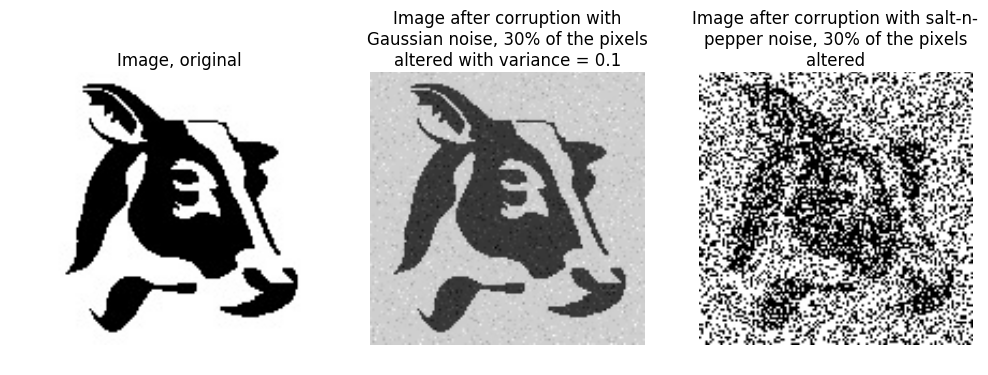

In [4]:
# proportion of pixels to alter
prop = 0.3
varSigma = 0.1

# im1 = imread("../images/manan_grey_resize.jpg")
# im1, im1_G, im1_S = shrink_corrupt_images(im1, prop, varSigma)
# im1_title1, im1_title2, im1_title3 = create_corrupt_titles(prop, varSigma, 1)

# im2 = imread("../images/mike_grey_resize.jpg")
# im2, im2_G, im2_S = shrink_corrupt_images(im2, prop, varSigma)
# im2_title1, im2_title2, im2_title3 = create_corrupt_titles(prop, varSigma, 2)

# im3 = imread("../images/zebra_grey_resize.jpg")
# im3, im3_G, im3_S = shrink_corrupt_images(im3, prop, varSigma)
# im3_title1, im3_title2, im3_title3 = create_corrupt_titles(prop, varSigma, 3)

im4 = imread("../images/cow_grey_resize.jpg")
im4, im4_G, im4_S = shrink_corrupt_images(im4, prop, varSigma)
im4_title1, im4_title2, im4_title3 = create_corrupt_titles(prop, varSigma, 4)

# display_three_images(im1, im1_title1, im1_G, im1_title2, im1_S, im1_title3)
# display_three_images(im2, im2_title1, im2_G, im2_title2, im2_S, im2_title3)
# display_three_images(im3, im3_title1, im3_G, im3_title2, im3_S, im3_title3)
display_three_images(im4, im4_title1, im4_G, im4_title2, im4_S, im4_title3)

In [5]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1), (1, N-2)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0), (M-2, 1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1), (M-2, N-2)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1, N-2), (i+1, N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1, j+1)]
        return n

In [6]:
print(im2.shape)
latent_im2 = np.copy(im2)
# print(im2.item((34, 123)))
# print(im2.item((36, 123)))
# print(im2.item((33, 45)))
    
def bookEnergy(image, xImage, point):
    #last term
    height, width = heightWidth(image)
    
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    xImage[point] = 1
    XY_multiplied_pos = np.multiply(image, xImage)
    finalSumPos = np.sum(XY_multiplied_pos)
    XN_convolved_pos = signal.convolve2d(xImage, kernel, mode='same')
    XN_multiplied_pos = np.multiply(xImage, XN_convolved_pos)
    middleSumPos = np.sum(XN_multiplied_pos)
    
    xImage[point] = -1
    XY_multiplied_neg = np.multiply(image, xImage)    
    finalSumNeg = np.sum(XY_multiplied_neg)
    XN_convolved_neg = signal.convolve2d(xImage, kernel, mode='same')
    XN_multiplied_neg = np.multiply(xImage, XN_convolved_neg)
    middleSumNeg = np.sum(XN_multiplied_neg)   
#     middleSumPos = 0
#     middleSumNeg = 0
    totalSumPos = finalSumPos + middleSumPos
    totalSumNeg = finalSumNeg + middleSumNeg
    return totalSumPos/10000, totalSumNeg/10000
    
def jointProb(image, xImage, point):
    Z = 1
    posEnergy, negEnergy = bookEnergy(image, xImage, point)
    posVal = 1/Z * np.exp(posEnergy)
    negVal = 1/Z * np.exp(negEnergy)
    return posVal, negVal
    
def ICM(image, display, lim):
    #set all the x variables to be = y variables
    #i.e. all the latent variables initialised as the image output
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X > 0.5] = 1
    X[X <= 0.5] = -1
    print("initialised X i.e. latent image")
    if(display == True):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(im2,cmap='gray')
        plt.show()
    for iterations in range(lim):
        flag = False
        for i in range(H):
            for j in range(W):
                point = (i,j)
                probPos, probNeg = jointProb(image, X, point)
                if(probPos > probNeg):
                    if(X[point] == -1):
                        flag = True
                        X[point] = 1
                elif(probNeg > probPos):
                    if(X[point] == 1):
                        flag = True
                        X[point] = -1
        if(display==True):
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(111)
            ax2.imshow(X,cmap='gray')
            plt.show()
        if(flag == False):
            print("bail early")
            break
        print("one iteration of ICM done")
    print("We compeleted ", iterations+1, " iterations")
    
    X[X != 1] = 0
    
    return X

im2_G_denoised = ICM(im2_G, display = False, lim = 5)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(im2_G_denoised,cmap='gray')
ax2 = fig.add_subplot(122)
ax2.imshow(im2,cmap='gray')
plt.show()

NameError: name 'im2' is not defined

In [7]:
def likeli(image, xImage, point):
    xImage[point] = 1
    k = np.copy(image)
    k = k - 0.5
    multipliedArrayPos = np.multiply(k, xImage)
    arraySumPos = np.sum(multipliedArrayPos)
    
    xImage[point] = -1
    multipliedArrayNeg = np.multiply(k, xImage)
    arraySumNeg = np.sum(multipliedArrayNeg)
    return arraySumPos, arraySumNeg

def E_weights_slow(xImage, point):
    H, W = heightWidth(xImage)
    retp = 0
    retn = 0
    for i in range(H):
        for j in range(W):
            ns = neighbours(i, j, H, W, 4)
            for n in ns:
                #in general, xImage[i, j] isn't the point we're considering
                wij = 0.2
                #consider the special case first, i.e. when we are looking at the point
                #that we want to evaluate
                if((i, j) == point):
                    #let xImage[i, j] = 1
                    #then if the neighbour is 1, we want the weight to be high
                    if(xImage[n] == 1):
                        wij = 2
                    retp +=  1 * xImage[n] * wij
                    #reset wij
                    wij = 0.2
                    #let xImage[i, j] = -1
                    #then if the neighbour is -1, we want the weight to be high
                    if(xImage[n] == -1):
                        wij = 2
                    retp += -1 * xImage[n] * wij
                else:
                    if(xImage[n] == xImage[(i, j)]):
                        wij = 1/wij
                    retp += xImage[(i, j)] * xImage[(i, j)] * wij
                    retn += xImage[(i, j)] * xImage[(i, j)] * wij
    return retp, retn

def weights_cases(wHigh, wLow, nSize = 4):
    convWeighted = []
    for i in range(nSize + 1):
        h = nSize - i
        l = i
        convWeighted.append(h*wHigh - l * wLow) #this corresponds exactly to the commented out manual input below
#     if(nSize == 4):
#         convWeighted.append(4*wHigh)              #case 1 below
#         convWeighted.append((3*wHigh) - wLow)     #case 2 below
#         convWeighted.append((2*wHigh) - (2*wLow)) #case 3 below
#         convWeighted.append(wHigh - (3*wLow))     #case 4 below
#         convWeighted.append(-4 * wLow)            #case 5 below
#     if(nSize == 8):
#         #to complete
    return convWeighted

def E_weights(xImage, point, wHigh, wLow, nSize):
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    if(nSize == 8):
        kernel = np.array([[1,1,1],
                           [1,0,1],
                           [1,1,1]])
    
    xPos = np.copy(xImage)
    xPos[point] = 1
    xNeg = np.copy(xImage)
    xNeg[point] = -1
    
    xConvolvedPos = signal.convolve2d(xPos, kernel, mode = 'same')
    xMultiplyPos = np.multiply(xPos, xConvolvedPos)
    xConvolvedNeg = signal.convolve2d(xNeg, kernel, mode = 'same')
    xMultiplyNeg = np.multiply(xNeg, xConvolvedNeg)
    
    
    #for both the positive and negative cases, xMultiply achieves the same matrix
    #as replacing each element i with the sum of i*j for j in neighbourhood(i)
    #in the 4-neighbourhood case, there are only 5 cases:
        #j =  i x4 (for all j) -> i replaced by 4   case 1
        #j =  i x3, j = -i x1  -> i replaced by 2   case 2
        #j =  i x2, j = -i x2  -> i replaced by 0   case 3
        #j =  i x1, j = -i x3  -> i replaced by -2  case 4
        #j = -i x4 (for all j) -> i replaced by -4  case 5
    #for each of these cases, we can consider how the weights would affect them directly
    #e.g. for case 3, i replaced by 0, we actually have i replaced by 2(1 * 1) + 2(-1 * 1)
    #so adding weights in would change that to 2(1 * 1 * w_high) + 2(-1 * 1 * w_low)
    #note in the 8-neighbourhood case, there are only 9 cases, it generalises to n+1 more or less
    #because every case has a mirror (all the same, all different) and as one goes up, one goes down
    
    
    weightedCases = weights_cases(wHigh, wLow, nSize)
    for i in range(nSize + 1):
        #in the 4-neighbourhood case, ele = 4, 2, 0, -2, -4, in that order i.e. corresponds to the cases as above
        ele = -2 * (i - 2)
        xMultiplyPos[xMultiplyPos == ele] = weightedCases[i]
        xMultiplyNeg[xMultiplyNeg == ele] = weightedCases[i]
    
    xSumPos = np.sum(xMultiplyPos)
    xSumNeg = np.sum(xMultiplyNeg)
    
    return xSumPos, xSumNeg
  
def E0(xImage, point):
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    xImage[point] = 1
    xConvolvedPos = signal.convolve2d(xImage, kernel, mode='same')
    xMultiplyPos = np.multiply(xImage, xConvolvedPos)
    xSumPos = np.sum(xMultiplyPos)
    xImage[point] = -1
    xConvolvedNeg = signal.convolve2d(xImage, kernel, mode='same')
    xMultiplyNeg = np.multiply(xImage, xConvolvedPos)
    xSumNeg = np.sum(xMultiplyNeg)
    return xSumPos, xSumNeg
    
def prob(image, xImage, point, wHigh, wLow, nSize):
    #p(y|x) = e^likeli
    #p(x) = e^E0
    #p(x, y) = p(y|x) * p(x)
    #we scale by a factor of 1000 for ease of calculation.
    #The results are not affected.
    
    L_pos, L_neg = likeli(image, xImage, point)
#     E_pos, E_neg = E0(xImage, point)
    E_pos, E_neg = E_weights(xImage, point, wHigh, wLow, nSize)
    pYX_pos, pYX_neg = np.exp(L_pos/1000), np.exp(L_neg/1000)
    pX_pos, pX_neg = np.exp(E_pos/1000), np.exp(E_neg/1000)
    
    pXY_pos, pXY_neg = pYX_pos * pX_pos, pYX_neg * pX_neg
    
    return pXY_pos, pXY_neg

# print(likeli(im2, im2, (39, 123)))
# print(E0(im2, (95, 127)))
# print(E0(im2, (34, 123)))
# print(prob(im2, im2, (31, 13)))

def ICM2(image, wHigh, wLow, nSize, lim, display):
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X > 0.5] = 1
    X[X <= 0.5] = -1
    if(display == True):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(im2, cmap='gray')
        ax.set_title("original image after noise corruption")
        plt.show()
    for iterations in range(lim):
        flag = False
        for i in range(H):
            for j in range(W):
                point = (i, j)
                prob_pos, prob_neg = prob(image, X, point, wHigh, wLow, nSize)
                if(prob_pos > prob_neg):
                    if(X[point] == -1):
                        X[point] = 1
                        flag = True
                else:
                    if(X[point] == 1):
                        X[point] = -1
                        flag = True
        print("one iteration done")
        if(display == True):
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(111)
            ax2.imshow(X, cmap='gray')
            title = "image after " + str(iterations+1) + " iterations of ICM"
            ax2.set_title(title)
            plt.show()
        if(flag == False):
            print("bailing early, no changes made")
            break
    print("We have completed ", iterations+1, " iterations")
    
    return X

def ICM2Saver(image, wHigh, wLow, nSize, lim, nType):
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X > 0.5] = 1
    X[X <= 0.5] = -1
    for iterations in range(lim):
        flag = False
        for i in range(H):
            for j in range(W):
                point = (i, j)
                prob_pos, prob_neg = prob(image, X, point, wHigh, wLow, nSize)
                if(prob_pos > prob_neg):
                    if(X[point] == -1):
                        X[point] = 1
                        flag = True
                else:
                    if(X[point] == 1):
                        X[point] = -1
                        flag = True
        print("one iteration done")
        t1, t2 = create_denoise_titles(1, iterations+1)
        f1 = "../images/q1/im4_g_ICM_eq_weight" + str(iterations+1)
        f2 = "../images/q1/im4_s_ICM_eq_weight" + str(iterations+1)
        if(nType == 'G'):
            save_three_images(im4, im4_title1, image, im4_title2, X, t1, f1)
        elif(nType == 'S'):
            save_three_images(im4, im4_title1, image, im4_title3, X, t2, f2)
        if(flag == False):
            print("bailing early, no changes made")
            break
    print("We have completed ", iterations+1, " iterations")
    
    return X

one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
We have completed  5  iterations
one iteration done
one iteration done
one iteration done
one iteration done
one iteration done
We have completed  5  iterations


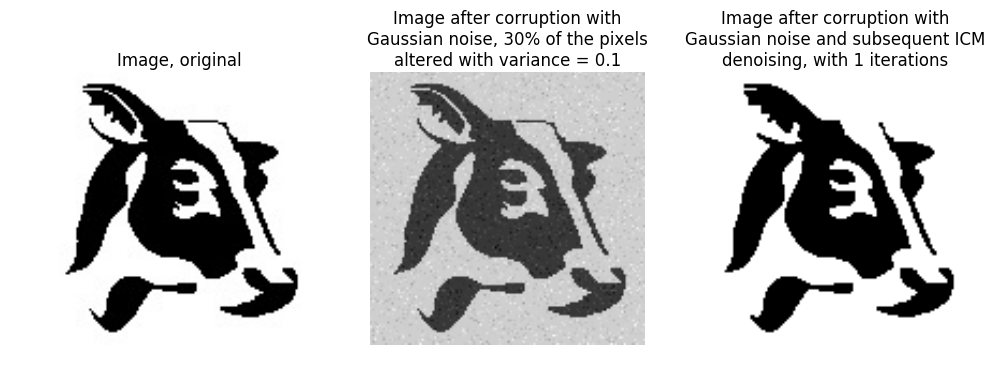

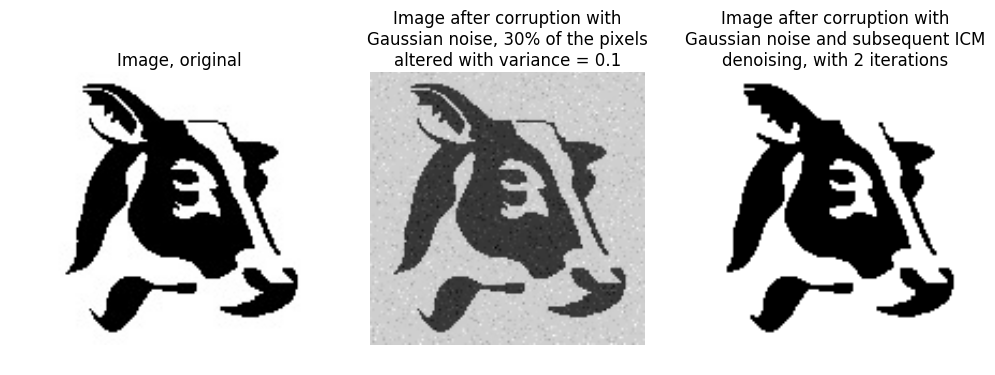

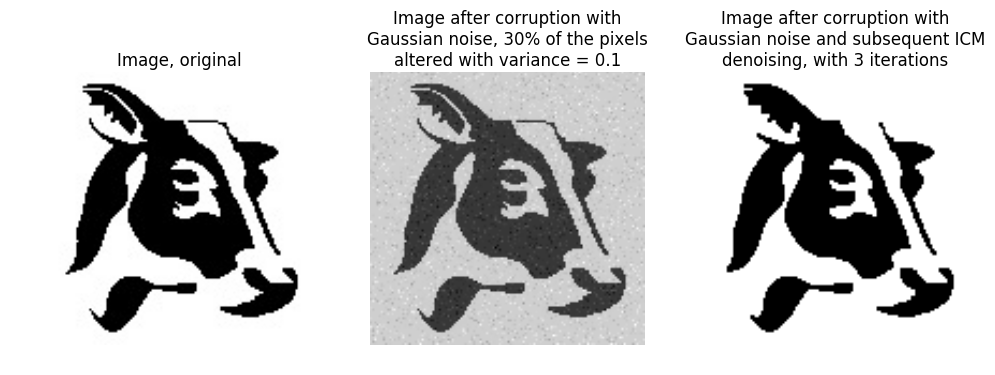

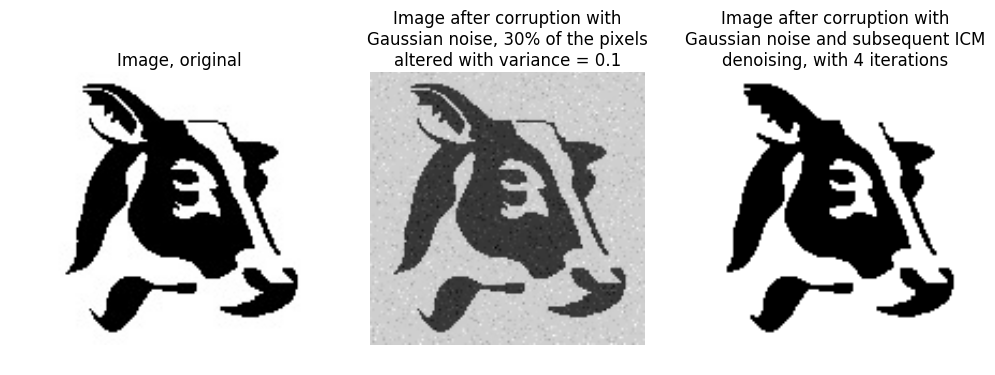

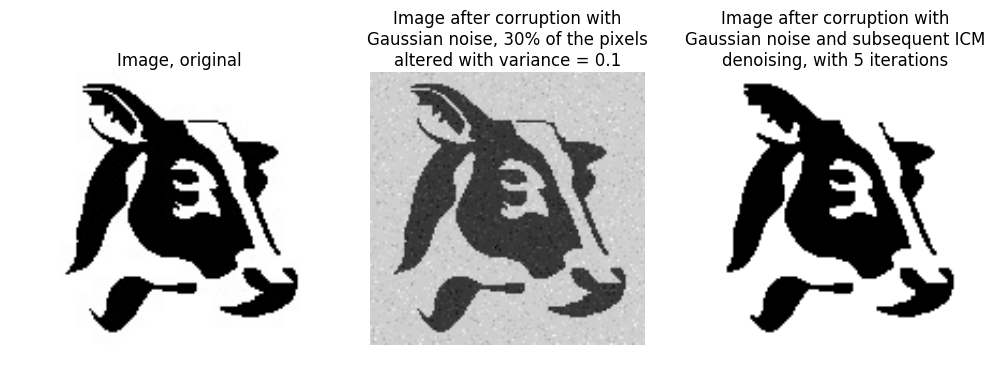

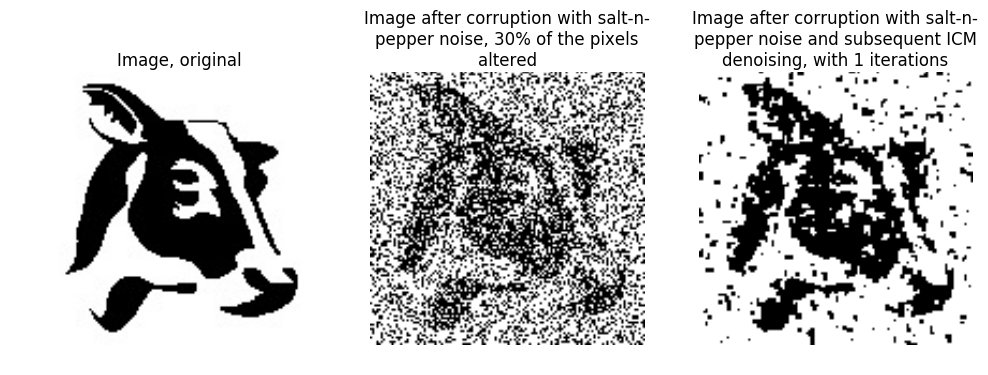

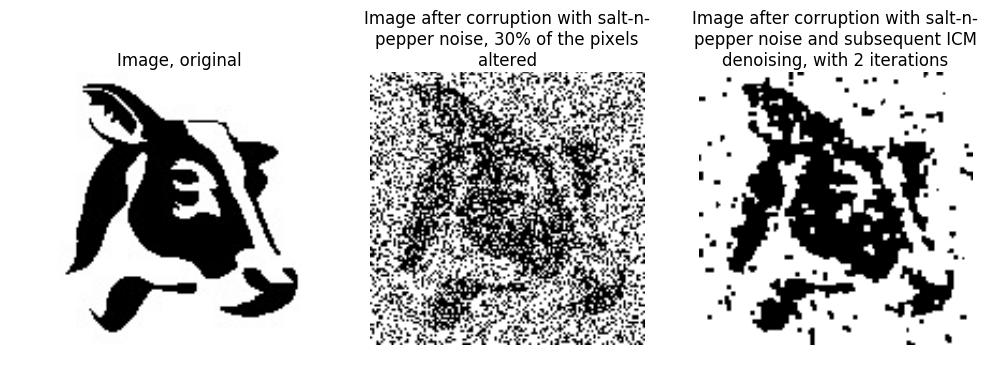

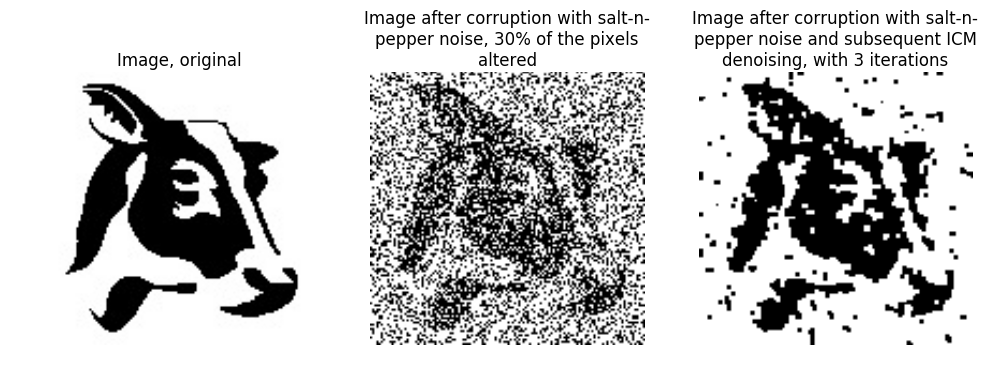

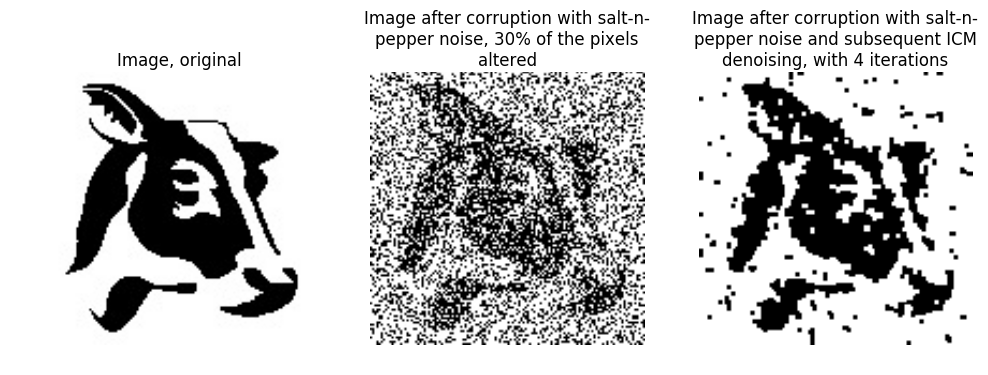

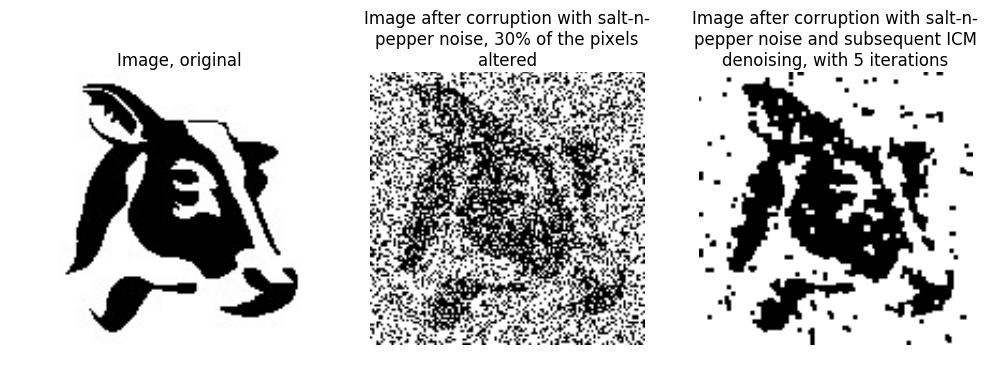

In [8]:
wHigh = 1
wLow = 1
nSize = 4

im4_G_denoised = ICM2Saver(im4_G, wHigh, wLow, nSize, 5, 'G')
im4_S_denoised = ICM2Saver(im4_S, wHigh, wLow, nSize, 5, 'S')

for iters in range(5):
    iters += 1

#     im1_G_denoised = ICM2(im1_G, wHigh, wLow, nSize, iters, display = False)
#     im1_S_denoised = ICM2(im1_S, wHigh, wLow, nSize, iters, display = False)
#     im1_G_denoised_title, im1_S_denoised_title = create_denoise_titles(1, iters)

#     im2_G_denoised = ICM2(im2_G, wHigh, wLow, nSize, iters, display = False)
#     im2_S_denoised = ICM2(im2_S, wHigh, wLow, nSize, iters, display = False)
#     im2_G_denoised_title, im2_S_denoised_title = create_denoise_titles(2, iters)
    
#     im3_G_denoised = ICM2(im3_G, wHigh, wLow, nSize, iters, display = False)
#     im3_S_denoised = ICM2(im3_S, wHigh, wLow, nSize, iters, display = False)
#     im3_G_denoised_title, im3_S_denoised_title = create_denoise_titles(3, iters)
    
    im4_G_denoised = ICM2(im4_G, wHigh, wLow, nSize, iters, display = False)
    im4_S_denoised = ICM2(im4_S, wHigh, wLow, nSize, iters, display = False)
    im4_G_denoised_title, im4_S_denoised_title = create_denoise_titles(4, iters)
    
    t1 = "../images/q1/im1_g_ICM_non_random" + str(iters)
    t2 = "../images/q1/im1_s_ICM_non_random" + str(iters)
    t3 = "../images/q1/im2_g_ICM_non_random" + str(iters)
    t4 = "../images/q1/im2_s_ICM_non_random" + str(iters)
    t5 = "../images/q1/im3_g_ICM_non_random" + str(iters)
    t6 = "../images/q1/im3_s_ICM_non_random" + str(iters)
    t7 = "../images/q1/im4_g_ICM_non_random" + str(iters)
    t8 = "../images/q1/im4_s_ICM_non_random" + str(iters)
    
#     save_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised, im1_G_denoised_title, t1)
#     save_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised, im1_S_denoised_title, t2)
#     save_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised, im2_G_denoised_title, t3)
#     save_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised, im2_S_denoised_title, t4)
#     save_three_images(im3, im3_title1, im3_G, im3_title2, im3_G_denoised, im3_G_denoised_title, t5)
#     save_three_images(im3, im3_title1, im3_S, im3_title3, im3_S_denoised, im3_S_denoised_title, t6)

#     display_three_images(im1, im1_title1, im1_G, im1_title2, im1_G_denoised, im1_G_denoised_title)
#     display_three_images(im1, im1_title1, im1_S, im1_title3, im1_S_denoised, im1_S_denoised_title)
#     display_three_images(im2, im2_title1, im2_G, im2_title2, im2_G_denoised, im2_G_denoised_title)
#     display_three_images(im2, im2_title1, im2_S, im2_title3, im2_S_denoised, im2_S_denoised_title)
#     display_three_images(im3, im3_title1, im3_G, im3_title2, im3_G_denoised, im3_G_denoised_title)
#     display_three_images(im3, im3_title1, im3_S, im3_title3, im3_S_denoised, im3_S_denoised_title)
    
    title1, title2 = create_denoise_titles(4, iters)
    fpath = "../images/q1/im4_GS_ICM_" + str(iters)
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121)
    ax1.set_title("\n".join(wrap(title1, 35)))
    ax1.axis('off')
    ax1.imshow(im4_G_denoised,cmap='gray')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("\n".join(wrap(title2, 35)))
    ax2.axis('off')
    ax2.imshow(im4_S_denoised,cmap='gray')
    
    plt.savefig(fpath,bbox_inches='tight')